In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import timeit
from functools import partial
import tabulate
import os.path
matplotlib.style.use('ggplot')

DATA_FILE = 'cs111_svm_dataset.csv'

In [4]:
data = pandas.read_csv(DATA_FILE)
BIAS_COLUMN = 'bias'
LABEL_COLUMN = 'Classification'

data[BIAS_COLUMN] = 1
data[LABEL_COLUMN].replace(0, -1, inplace=True)


\begin{figure}[ht]
	\label{fig:data}
	\includegraphics[width=0.95\textwidth]{data_only_plot.png}
	\caption{Plot of the raw data}
\end{figure}



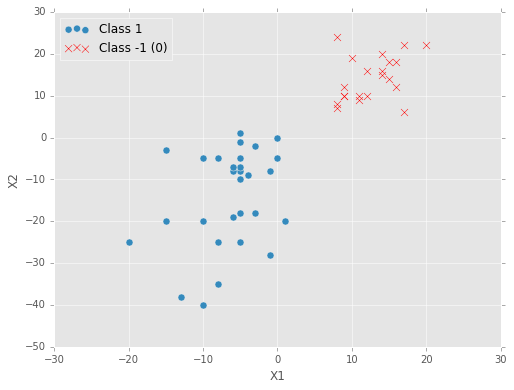

In [5]:
OUTPUT_DIR = r'/Users/guydavidson/Documents/CS111/svm_gradient_descent'
LATEX_FIGURE_FORMAT = """
\\begin{{figure}}[ht]
\t\\label{{fig:{label}}}
\t\\includegraphics[width=0.95\\textwidth]{{{name}}}
\t\\caption{{{caption}}}
\\end{{figure}}
"""

X_MIN = -30
X_MAX = 30
Y_MIN = -50
Y_MAX = 30

def save_and_print_latex(figure_name, caption, label):
    plt.savefig(os.path.join(OUTPUT_DIR, figure_name))
    print LATEX_FIGURE_FORMAT.format(name=figure_name, label=label, caption=caption)

    
def line_from_theta(theta, x_range):
    b0, b1, b2 = theta
    return -1.0 * (b0 + b1 * x_range) / b2


def plot_data(data, theta=None, figure_name=None, label='', caption=''):
    ax = data[data[LABEL_COLUMN] == 1].plot(kind='scatter', x='X1', 
                                            y='X2', marker='o', s=50,
                                            label='Class 1', figsize=(8, 6))
    data[data[LABEL_COLUMN] == -1].plot(kind='scatter', x='X1', y='X2', 
                                        marker='x', s=50, 
                                        c='red', label='Class -1 (0)', ax=ax)
    ax.set_xlabel('X1')
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    
    if theta is not None:
        x_min = data.min()['X1']
        x_max = data.max()['X1']
        x_range = np.linspace(X_MIN, X_MAX)

        ax.plot(x_range, line_from_theta(theta, x_range), color='black', ls='--')
        
    ax.legend(loc=2)
    
    if figure_name is not None:
        save_and_print_latex(figure_name, caption, label)
    
    plt.show()
    
plot_data(data, figure_name='data_only_plot.png', 
          label='data', caption='Plot of the raw data')

In [6]:
DATA_COLUMN_PREFIX = 'X'

def generate_relevant_columns(data, include_bias=True, prefix=DATA_COLUMN_PREFIX):
    columns = data.filter(like=prefix).columns
    if include_bias:
        columns = columns.insert(0, BIAS_COLUMN)
        
    return columns

def loss_function(data, theta, label_column=LABEL_COLUMN, 
                  data_cols_generator=generate_relevant_columns):
    return np.log(1.0 + np.exp(-1.0 * data[label_column] * 
                             data.filter(items=data_cols_generator(data))
                               .values.dot(theta)))


def error_function(data, theta, label_column=LABEL_COLUMN, 
                   data_cols_generator=generate_relevant_columns):
    return np.mean(loss_function(data, theta, label_column, data_cols_generator))
    

def generate_partial_derivatives(label_column=LABEL_COLUMN, 
                                 data_cols_generator=generate_relevant_columns):
    return pandas.concat([-1 * data[label_column] * data[col] 
                          for col in data_cols_generator(data)], axis=1)


def gradient(data, theta, partial_derivatives, 
             label_column=LABEL_COLUMN, 
             data_cols_generator=generate_relevant_columns):
    return partial_derivatives.multiply(1.0 / (
            1.0 + np.exp(data[label_column] * data.filter(
                    items=data_cols_generator(data)).values.dot(theta))), 
                                        axis=0).sum()


GRADIENT_CHECK_STEP = 0.001


def gradient_check(data, theta, step=GRADIENT_CHECK_STEP,
                   label_column=LABEL_COLUMN, 
                   data_cols_generator=generate_relevant_columns):
    """
    Implement gradient checking using the centered formula for the derivative:
    f'(x) = (f(x + h) - f(x - h)) / 2h
    """
    step_configurations = ([step, 0, 0], [0, step, 0], [0, 0, step])
    
    gradients = [(loss_function(data, theta + step_config) - \
                  loss_function(data, theta - step_config)) /  \
                (2 * step) for step_config in step_configurations]
    
    return [grad.sum() for grad in gradients]


def compare_gradients(step=GRADIENT_CHECK_STEP, label_column=LABEL_COLUMN, 
                      data_cols_generator=generate_relevant_columns):
    test_theta = np.random.random(3)
    partial_derivatives = generate_partial_derivatives(label_column, 
                                                       data_cols_generator)
    
    return gradient_check(data, test_theta, step, 
                          label_column, data_cols_generator) - \
            gradient(data, test_theta, partial_derivatives, 
                     label_column, data_cols_generator)


LEARNING_RATE = 1.0
DEFAULT_EPOCHS = 1000
DEFAULT_GRAPH_INTERVAL = 10
MIN_DELTA_ERROR = 10 ** -7


def split_data_into_batches(data, batch_size=None):
    if batch_size is None:
        return [data]
    
    if 1 == batch_size:
        return data.sample(frac=1)
    
    shuffled_rows = range(len(data))
    np.random.shuffle(shuffled_rows)
    
    return [data.iloc[shuffled_rows[i * batch_size:(i + 1) * batch_size]] 
            for i in range(len(data) / batch_size)]


def train_model(data, theta=None, batch_size=None, num_epochs=DEFAULT_EPOCHS, 
                learning_rate=LEARNING_RATE, min_delta_error=MIN_DELTA_ERROR, 
                should_print=True, should_graph=False, 
                graph_interval=DEFAULT_GRAPH_INTERVAL,
                label_column=LABEL_COLUMN, 
                data_cols_generator=generate_relevant_columns):
    if batch_size > len(data):
        raise ValueError('Batch size cannot be larger than the entire data. Aborting...')
    
    if theta is None:
        theta = np.random.rand(3) * 10
        
    learning_rate = float(learning_rate)
        
    last_error = float('inf')

    partial_derivatives = generate_partial_derivatives(label_column, data_cols_generator)
    
    for i in xrange(num_epochs):
        for batch in split_data_into_batches(data, batch_size):        
            error = error_function(data, theta, label_column, data_cols_generator)
            if should_print:
                print 'In epoch {i} the error is {error}'.format(i=i, error=error)

            if last_error - error < min_delta_error:
                if should_print:
                    print 'Reached a change in error below the minimum, terminating'
                
                return theta

            last_error = error

            if should_graph and 0 == i % graph_interval:
                plot_data(data, 
                          theta,
                          figure_name='learning_plot_epoch_{i}.png'.format(i=i), 
                          label='epoch_{i}'.format(i=i), 
                          caption='Epoch {i} with a learning rate $\\eta={lr}$, $err={err:.4e}$'
                              .format(i=i, err=error, lr=learning_rate))

            theta_grad = gradient(data, theta, partial_derivatives, 
                                  label_column, data_cols_generator)
            theta -= learning_rate * theta_grad
        
    return theta


DEFAULT_LEARNING_RATES = [10.0, 5.0, 2.0, 1.0, 0.5]
DEFAULT_BATCH_SIZES = [1, 10, 25, None]

def evaluate_convergence_rate(data, learning_rates=DEFAULT_LEARNING_RATES, 
                              batch_sizes=DEFAULT_BATCH_SIZES):
    
    results = [['Learning Rate'] + batch_sizes] + \
            [[rate] + 
                   [timeit.timeit(partial(train_model, data, should_print=False, 
                                          learning_rate=rate, batch_size=batch), number=10)
                    for batch in batch_sizes]
                 for rate in learning_rates]
    
    print tabulate.tabulate(results, tablefmt="latex")
    

In epoch 0 the error is 200.409316273

\begin{figure}[ht]
	\label{fig:epoch_0}
	\includegraphics[width=0.95\textwidth]{learning_plot_epoch_0.png}
	\caption{Epoch 0 with a learning rate $\eta=1.0$, $err=2.0041e+02$}
\end{figure}



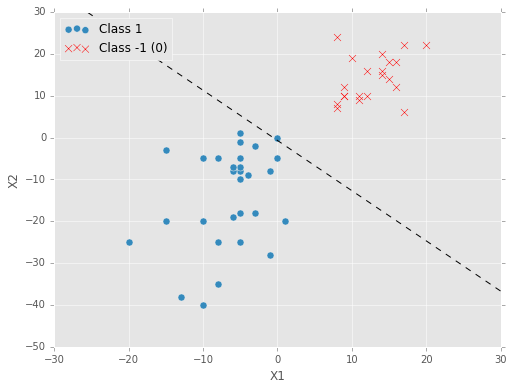

In epoch 1 the error is 7.15172948179e-08
In epoch 2 the error is 7.15170390856e-08
Reached a change in error below the minimum, terminating


/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: overflow encountered in exp


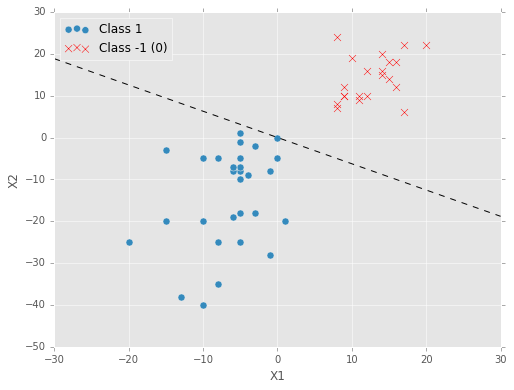

In [7]:
theta = train_model(data, should_graph=1, graph_interval=10, min_delta_error=10**-4)
plot_data(data, theta)

In [23]:
evaluate_convergence_rate(data)

\begin{tabular}{lrrrr}
\hline
 Learning Rate &  1        & 10        & 25        &            \\
 10.0          &  0.110549 &  0.117903 &  0.106902 &  0.0972071 \\
 5.0           &  0.102907 &  0.12174  &  0.915894 &  0.0974281 \\
 2.0           &  0.108109 &  0.118326 &  0.123955 &  0.105843  \\
 1.0           &  0.133916 &  0.110293 &  2.41302  &  0.237     \\
 0.5           & 18.1837   & 20.0671   & 21.334    & 18.1467    \\
\hline
\end{tabular}


/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: overflow encountered in exp



\begin{figure}[ht]
	\label{fig:final}
	\includegraphics[width=0.95\textwidth]{learning_plot_final.png}
	\caption{Final model, with $err=4.212 \times 10^{-07}$, with parameters $b_0 = 10.768$, $b_1 = -222.072$, and $b_2 = -348.229$.}
\end{figure}



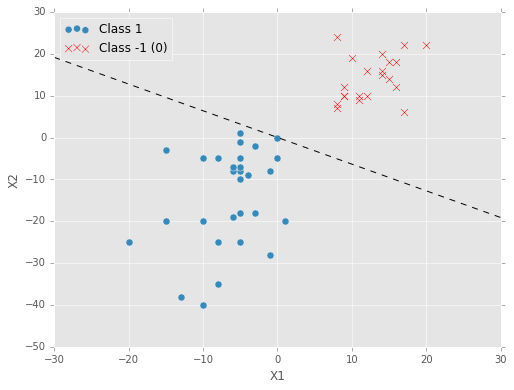

In [85]:
plot_data(data, theta, 'learning_plot_final.png', 'final', 
          'Final model, with $err=4.212 \\times 10^{-07}$, with parameters ' + \
            '$b_0 = 10.768$, $b_1 = -222.072$, and $b_2 = -348.229$.')

In [8]:
theta

array([  12.54130531, -441.36184812, -702.96565816])

In [ ]:
loss_function(data, theta)

In [ ]:
generate_relevant_columns(data, True)

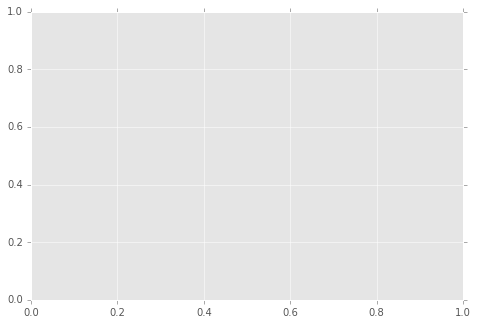